In [31]:
import pandas as pd
import numpy as np
from utils.imageprocessing import *
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load data

In [18]:
df_codis_color_info =  pd.read_csv("data/codis_info.csv")

### Preprocessing

In [44]:
color1 = df_codis_color_info.filter(regex = "color1_[RGB]").values
color2 = df_codis_color_info.filter(regex = "color2_[RGB]").values
color3 = df_codis_color_info.filter(regex = "color3_[RGB]").values

In [45]:
# 1순위, 2순위 색상으로 3순위 색상 추천받기
X0 = np.concatenate([color1, color2], axis = 1)
y = color3

In [46]:
# 데이터 수가 워낙 적다
X0_train, X0_test, y_train, y_test = train_test_split(X0, y, test_size = 0.001)

In [47]:
X0_train.shape, X0_test.shape, y_train.shape, y_test.shape

((1114, 6), (2, 6), (1114, 3), (2, 3))

In [48]:
### change form (sample, timesteps, input_dim)
X_train = X0_train.reshape((X0_train.shape[0], 2, 3)) /256
X_test = X0_test.reshape((X0_test.shape[0], 2, 3)) /256

In [49]:
X_train.shape

(1114, 2, 3)

In [50]:
### change form (sample, timesteps, input_dim)
X = X0.reshape((X0.shape[0], 2, 3)) /256
y = y

### Modeling(RNN)

In [51]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.layers import TimeDistributed
from keras.optimizers import SGD

In [52]:
np.random.rand(0)
model_RNN = Sequential()
model_RNN.add(SimpleRNN(10, input_shape=(2,3)))
model_RNN.add(Dense(10, activation="relu"))
model_RNN.add(Dense(3, activation="linear"))
model_RNN.compile(loss="mse", optimizer="adam")

In [53]:
history_RNN = model_RNN.fit(X, y, epochs=100, verbose=0)

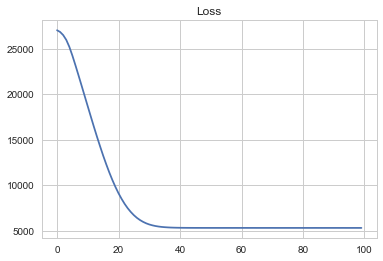

In [54]:
plt.plot(history_RNN.history["loss"])
plt.title("Loss")
plt.show()

### 확인

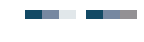

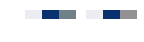

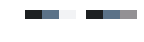

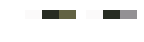

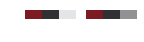

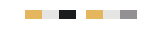

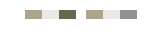

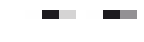

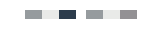

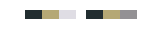

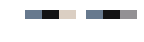

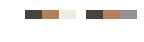

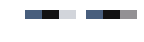

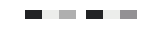

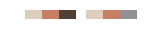

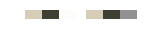

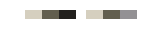

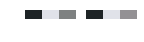

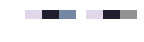

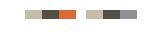

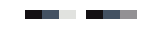

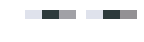

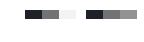

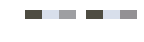

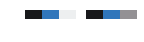

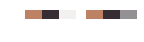

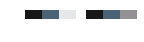

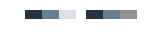

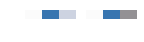

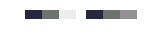

In [55]:
for idx in range(30):
    input_color = np.vstack([color1[idx], color2[idx]])[np.newaxis, :, :]
    color_3_pre = model_RNN.predict(input_color)[0]

    true = [color1[idx], color2[idx], color3[idx]]
    predict = [color1[idx], color2[idx], color_3_pre]
    #print(color3[idx])
    #print(color_3_pre)
    bar_true = plot_colors([0.33, 0.33, 0.33], true, h=50, w=300)
    bar_predict = plot_colors([0.33, 0.33, 0.33], predict, h=50, w=300)
    
    plt.figure(figsize = (2, 1))  

    plt.subplot(1, 2, 1)
    plt.imshow(bar_true)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(bar_predict)
    plt.axis('off')
    plt.show()

대부분의 예측 결과과 무채색이다

### Modeling(NN)

In [57]:
np.random.rand(0)
model_NN = Sequential()
model_NN.add(Dense(5, input_dim=6, activation = "relu"))
model_NN.add(Dense(3, activation = "linear"))
model_NN.compile(loss="mse", optimizer="adam")

In [58]:
X = X0/256

In [59]:
history_NN = model_NN.fit(X, y, epochs=1000, verbose=0)

In [60]:
# 모델저장
model_NN.save('model/model_nn.hdf5')

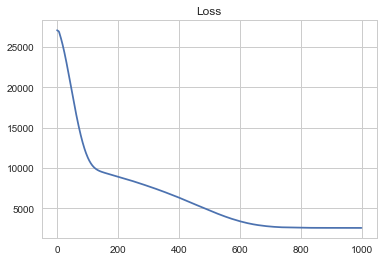

In [62]:
plt.plot(history_NN.history["loss"])
plt.title("Loss")
plt.show()

### 확인

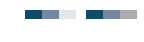

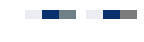

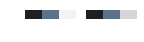

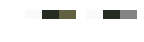

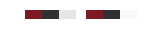

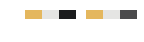

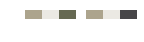

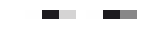

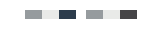

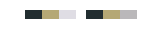

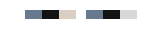

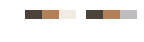

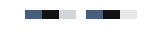

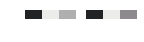

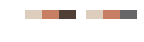

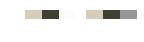

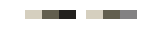

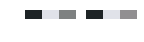

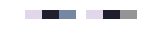

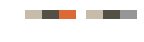

In [63]:
for idx in range(20):
    input_color = np.hstack([color1[idx], color2[idx]]).reshape(1,6) /256
    color_3_pre = model_NN.predict(input_color)[0]

    true = [color1[idx], color2[idx], color3[idx]]
    predict = [color1[idx], color2[idx], color_3_pre]
    
    bar_true = plot_colors([0.33, 0.33, 0.33], true, h=50, w=300)
    bar_predict = plot_colors([0.33, 0.33, 0.33], predict, h=50, w=300)
    
    plt.figure(figsize = (2, 1))  

    plt.subplot(1, 2, 1)
    plt.imshow(bar_true)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(bar_predict)
    plt.axis('off')
    plt.show()

마찬가지로 대부분 무채색이 예측 결과다

### ColorMind 사용
모델을 이용한 색상 추천은 대부분 무채색이기에 다양한 색상 추천을 위해 Color mind api 사용

In [65]:
import requests
import json

In [66]:
url = "http://colormind.io/api/"
data = {
    'model' : "default",
    'input' : [[44, 43, 44], [90, 83, 82], "N"]
}

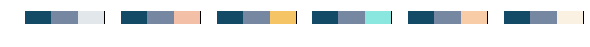

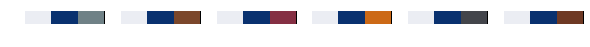

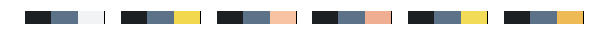

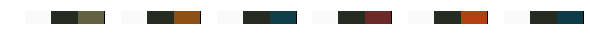

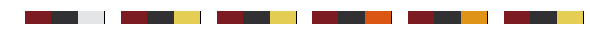

In [67]:
for idx in range(5):
    input_color = [color1[idx].tolist(), color2[idx].tolist(), "N"]
    data = {
    'model' : "default",
    'input' : input_color}
    
    plt.figure(figsize = (10, 1)) 
    
    true = [color1[idx], color2[idx], color3[idx]]
    bar_true = plot_colors([0.33, 0.33, 0.33], true, h=50, w=300)
    plt.subplot(1, 6, 1)
    plt.imshow(bar_true)
    plt.axis('off')

    for rand_idx in range(5):
        response = requests.post(url, data = json.dumps(data))
        color_3_pre = np.array(response.json()["result"][2])
        predict = [color1[idx], color2[idx], color_3_pre]
        bar_predict = plot_colors([0.33, 0.33, 0.33], predict, h=50, w=300)

        plt.subplot(1, 6, 2 + rand_idx)
        plt.imshow(bar_predict)
        plt.axis('off')
    plt.show()
    

### 색깔 추천 (컬러마인드에서 예측한 값과 가까운 값 , 예측한 값, 컬러마인드 나머지1)

[array([243, 190, 166]), array([173.60344, 171.73236, 173.79567], dtype=float32), array([253, 221, 166])]


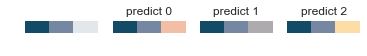

In [77]:
idx = 0
input_color = np.hstack([color1[idx], color2[idx]]).reshape(1,6)
 
# true color values
true = [color1[idx], color2[idx], color3[idx]]
bar_true = plot_colors([0.33, 0.33, 0.33], true, h=50, w=300)

# predict color values using dnn
color_3_pre = model_NN.predict(input_color/256)[0]
#print(color_3_pre)

# 유클리디안 거리를 사용하여 더 비슷한 색상을 찾는다
li_similar = []
li_color_3_colormind = []
request_color = [color1[idx].tolist(), color2[idx].tolist(), "N"]
#print(request_color)
data = {'model' : "default",'input' : request_color}
for _ in range(3):
    response = requests.post(url, data = json.dumps(data))
    color_3_colormind = np.array(response.json()["result"][2])
    li_similar.append(np.linalg.norm(color_3_pre - color_3_colormind))
    li_color_3_colormind.append(color_3_colormind)
    
# 유사도가 가장 큰 색상 선택
li_idx = np.argsort(np.array(li_similar))

li_color_3_recom = []
# recommend color1
li_color_3_recom.append(li_color_3_colormind[li_idx[0]])
# recommend color2
li_color_3_recom.append(color_3_pre)
# recommend color3
li_color_3_recom.append(li_color_3_colormind[li_idx[1]])


# draw color bar
plt.subplot(1, 4, 1)
plt.imshow(bar_true)
plt.axis('off')
bar_true = plot_colors([0.33, 0.33, 0.33], true, h=50, w=300)
for recom_idx in range(3):
    recom = [color1[idx], color2[idx],  li_color_3_recom[recom_idx]]
    bar_recom = plot_colors([0.33, 0.33, 0.33], recom, h=50, w=300)
    plt.subplot(1, 4, 2+recom_idx)
    plt.imshow(bar_recom)
    plt.title('predict {}'.format(recom_idx))
    plt.axis('off')

#print(true)
print(li_color_3_recom)
# predict = [color1[idx], color2[idx], color_3_pre]
# bar_predict = plot_colors([0.33, 0.33, 0.33], predict, h=50, w=300)

In [80]:
from keras.models import load_model
import pandas as pd
import numpy as np
import requests
import urllib
import json

In [81]:
def get_hex(r, g, b):
    return '#%02x%02x%02x' % ( r, g, b)
def get_hex(color): 
    return '#%02x%02x%02x' % ( color[0], color[1], color[2])
def recommand_color(color1, color2):
    '''
    recommand 3 colors
    input : main color1(RGB), sub color2(RGB)
    output : 
    recommand color1(RGB, nearest colormind from predict), 
    recommand color2(RGB, predict), 
    recommand color3(RGB, second colormind from predict)
    '''
    # 2*3 -> 1,6
    input_color = np.hstack([color1, color2]).reshape(1,6)
 
    # predict color values using dnn
    model = load_model("model/model_nn.hdf5")
    color_3_pre = model.predict(input_color/256)[0]
    
    # get color values using colormind 
    li_similar = []
    li_color_3_colormind = []
    request_color = [color1, color2, "N"] 
    data = {'model' : "default",'input' : request_color}
    url = 'http://colormind.io/api/'
    for _ in range(3):
        response = requests.post(url, data = json.dumps(data))
        color_3_colormind = np.array(response.json()["result"][2])
        li_similar.append(np.linalg.norm(color_3_pre - color_3_colormind))
        li_color_3_colormind.append(color_3_colormind)

    li_idx = np.argsort(np.array(li_similar))
    
    c1 = get_hex(li_color_3_colormind[li_idx[0]])
    c2 = get_hex(color_3_pre.astype(int))
    c3 = get_hex(li_color_3_colormind[li_idx[1]])
   
    return c1, c2, c3

In [82]:
recommand_color([19.32861825, 74.59376488, 101.89400857], [118.23544433, 136.80332436, 161.93016993])

('#f7ea9d', '#adabad', '#f6dc56')